In [1]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/DS4/Project/Mini/RecSys/data') 
train_path = data_path / 'ratings.dat'

# 2번 셀 ─ 기존 load_data 함수 교체
def load_data(data_path: Path, nrows=None):
    """
    MovieLens(ratings.dat) ↔︎ Yoochoose(.dat) 파일을 자동 인식하여 로드
    """
    # ① 파일 첫 줄을 보고 구분자·컬럼 수 판별
    with open(data_path, 'r') as f:
        first = f.readline()

    if '::' in first:           # MovieLens (UserId::ItemId::Rating::Time)
        sep, col_names = '::', ['UserId', 'ItemId', 'Rating', 'Time']
    elif ',' in first:          # Yoochoose (SessionId,Time,ItemId)
        sep, col_names = ',',   ['SessionId', 'Time', 'ItemId']
    else:                       # 기타(탭 등) → 탭으로 시도
        sep, col_names = '\t',  ['SessionId', 'Time', 'ItemId']

    # ② 실제 읽기
    data = pd.read_csv(
        data_path,
        sep=sep,
        header=None,
        names=col_names,
        engine='python',   # 가변 구분자 안전
        nrows=nrows,
    )
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# Step 1. 데이터 전처리



In [3]:
# 각 사용자(UserId)별로 평가한 아이템(행)의 개수를 계산하여 세션 길이(활동 횟수)를 구함
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [4]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [5]:
session_length.min(), session_length.max()

(20, 2314)

In [6]:
session_length.quantile(0.999)

1343.181000000005

In [7]:
long_session = session_length[session_length==200].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
406366,2438,908,3,974222921
406379,2438,2294,3,974222921
406412,2438,3812,5,974222921
406418,2438,3835,2,974222921
406427,2438,1186,4,974222921
...,...,...,...,...
406356,2438,3948,4,979792076
406461,2438,2502,4,981262001
406372,2438,1466,4,981322989
406413,2438,1131,5,987127691


In [8]:
# 세션 길이를 구간별로 그룹화 (예: 1-5, 6-10, 11-15, ...)
max_length = min(session_length.max(), 50)  # 최대 50까지만 보기
session_length_limited = session_length[session_length <= max_length]

# 5개씩 구간으로 나누어 그룹화
bins = range(1, max_length + 6, 5)  # 1-5, 6-10, 11-15, ...
session_length_binned = pd.cut(session_length_limited, bins=bins, right=False, include_lowest=True)

length_count = session_length_binned.value_counts().sort_index()
length_percent_cumsum = length_count.cumsum() / length_count.sum()

length_percent_cumsum

[1, 6)      0.000000
[6, 11)     0.000000
[11, 16)    0.000000
[16, 21)    0.047964
[21, 26)    0.273843
[26, 31)    0.451199
[31, 36)    0.601785
[36, 41)    0.753486
[41, 46)    0.871166
[46, 51)    1.000000
Name: count, dtype: float64

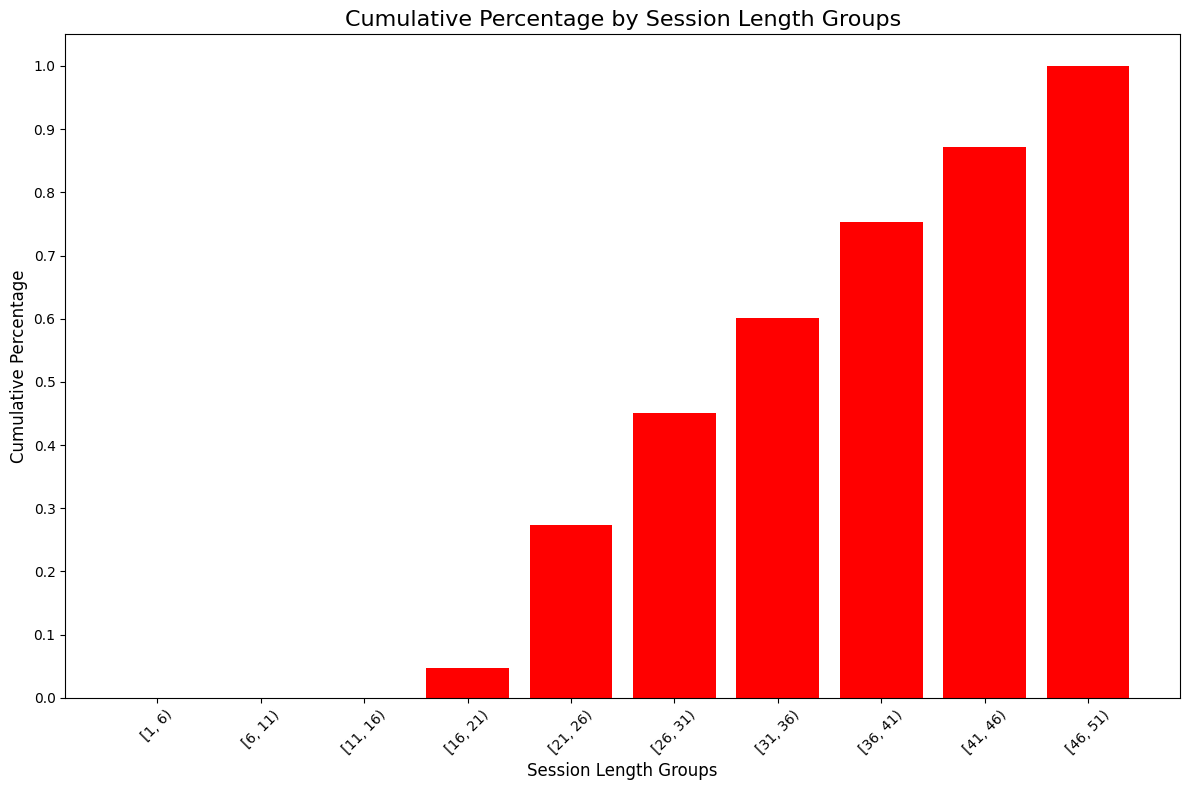

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
# x축 라벨을 구간 이름으로 변경
x_labels = [str(interval) for interval in length_percent_cumsum.index]
x_positions = range(len(x_labels))

plt.bar(x=x_positions, height=length_percent_cumsum, color='red')
plt.xticks(x_positions, x_labels, rotation=45)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.title('Cumulative Percentage by Session Length Groups', size=16)
plt.xlabel('Session Length Groups', size=12)
plt.ylabel('Cumulative Percentage', size=12)
plt.tight_layout()
plt.show()

In [10]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [11]:
type(latest)

int

In [12]:
SECONDS_IN_30_DAYS = 30 * 24 * 60 * 60
month_ago = latest - SECONDS_IN_30_DAYS     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

data['SessionId'] = data['UserId']

data.head()     

,UserId,ItemId,Rating,Time,SessionId
28225,195,2808,3,1044220118,195
27759,195,1254,4,1044552222,195
27921,195,1456,2,1044662852,195
28443,195,468,3,1044985356,195
28255,195,2748,1,1044987808,195


In [13]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [14]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time,SessionId
58836,398,2028,4,1044565425,398
58784,398,2762,5,1044565753,398
58730,398,2628,3,1044566296,398
58837,398,3697,2,1044566464,398
58645,398,1196,4,1044567541,398
62105,419,2424,4,1044900624,419
62170,419,2028,5,1044900801,419
62078,419,1196,5,1044900920,419
62145,419,2762,5,1044901328,419
62071,419,3793,4,1044901354,419


In [15]:
test_path = data_path / 'yoochoose-test.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(214507224, 1178837797)

In [16]:
# ... 기존 코드 삭제 후 교체 ...
def split_by_date(data: pd.DataFrame, n_days: int):
    """n_days 기준으로 train / test(또는 valid) 분할"""
    final_time = data['Time'].max()

    # 1) 각 User(=Session)의 마지막 클릭 시각
    user_last_time = data.groupby('UserId')['Time'].max()

    # 2) n_days(초) 이전·이후로 분리
    seconds = n_days * 24 * 60 * 60
    user_in_train = user_last_time[user_last_time < final_time - seconds].index
    user_in_test  = user_last_time[user_last_time >= final_time - seconds].index

    # 3) 데이터 선택
    before_date = data[data['UserId'].isin(user_in_train)]
    after_date  = data[data['UserId'].isin(user_in_test)]

    # 4) test/valid 세트는 train 에 존재하는 아이템만 사용
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]

    return before_date, after_date

In [17]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [18]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [19]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 28
	 Sessions: 6
	 Items: 7
	 First Time : 1044067155
	 Last Time : 1045862546

* valid Set Stats Info
	 Events: 5
	 Sessions: 2
	 Items: 4
	 First Time : 1046106127
	 Last Time : 1046199975

* test Set Stats Info
	 Events: 2
	 Sessions: 1
	 Items: 2
	 First Time : 1046368417
	 Last Time : 1046369710



In [20]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [21]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [22]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [23]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
58836,398,2028,4,1044565425,398,0
58784,398,2762,5,1044565753,398,1
58730,398,2628,3,1044566296,398,2
58837,398,3697,2,1044566464,398,3
58645,398,1196,4,1044567541,398,4
62105,419,2424,4,1044900624,419,5
62170,419,2028,5,1044900801,419,0
62078,419,1196,5,1044900920,419,4
62145,419,2762,5,1044901328,419,1
62071,419,3793,4,1044901354,419,6


In [24]:
tr_dataset.click_offsets

array([ 0,  5, 10, 15, 21, 24, 28], dtype=int32)

In [25]:
tr_dataset.session_idx

array([0, 1, 2, 3, 4, 5])

In [28]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size: int = 50):
        self.dataset = dataset
        # 세션 수보다 크면 자동 축소
        self.batch_size = min(batch_size, len(self.dataset.session_idx))

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        real_batch   = self.batch_size                     # 이미 min 처리됨
        first_iters  = np.arange(real_batch)
        last_session = real_batch - 1
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]
        end   = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]
        mask  = np.array([])
        finished = False
        return start, end, mask, last_session, finished

    def update_status(
        self, start: np.ndarray, end: np.ndarray,
        min_len: int, last_session: int, finished: bool
    ):
        start += min_len
        # ★ self.batch_size 대신 현재 배열 길이 사용
        cur_len = len(start)
        mask = np.arange(cur_len)[(end - start) == 1]

        for i, idx in enumerate(mask, start=1):
            new_session = last_session + i
            if new_session > self.dataset.session_idx[-1]:
                finished = True
                break
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]
            end[idx]   = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)
        return start, end, mask, last_session, finished

In [29]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
58836,398,2028,4,1044565425,398,0
58784,398,2762,5,1044565753,398,1
58730,398,2628,3,1044566296,398,2
58837,398,3697,2,1044566464,398,3
58645,398,1196,4,1044567541,398,4
62105,419,2424,4,1044900624,419,5
62170,419,2028,5,1044900801,419,0
62078,419,1196,5,1044900920,419,4
62145,419,2762,5,1044901328,419,1
62071,419,3793,4,1044901354,419,6


In [30]:
iter_ex = iter(tr_data_loader)

In [31]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 5 1 3]
Label Item Idx are :       [1 0 2 0]
Previous Masked Input Idx are []


In [32]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'], run_eagerly=True)
    model.summary()
    return model

In [35]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [36]:
model = create_model(args)

2025-07-11 12:23:01.470606: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-07-11 12:23:01.470648: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-11 12:23:01.470655: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-07-11 12:23:01.470838: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-11 12:23:01.470862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (2, 1, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU (GRU)                       │ [(2, 50), (2, 50)]     │         8,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (2, 50)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (2, 7)                 │           357 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,207 (35.96 KB)

 Trainable params: 9,207 (35.96 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 user는 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')
    gru_layer.reset_states()   # ← 인자 없이 호출 (배치 전체 0 초기화)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [38]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

# 학습 끝난 후
model.save(data_path / 'trained_model.keras')

# 학습된 모델을 불러옵니다.
model = tf.keras.models.load_model(data_path / 'trained_model.keras')

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluation: 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]


	 - Recall@20 epoch 1: 1.000000
	 - MRR@20    epoch 1: 0.225000



Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 20.62it/s]


	 - Recall@20 epoch 2: 1.000000
	 - MRR@20    epoch 2: 0.225000



Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 20.26it/s]


	 - Recall@20 epoch 3: 1.000000
	 - MRR@20    epoch 3: 0.225000



In [39]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


2025-07-11 12:23:10.923802: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Invalid input_h shape: [2,1,50] [1,1,50]
	 [[{{node CudnnRNNV3}}]]
Evaluation: 1it [00:00,  4.99it/s]

	 - Recall@20: 1.000000
	 - MRR@20: 0.250000



# 프로젝트 요약 : MovieLens · Session-based Recommendation 실험

이번 프로젝트는 **MovieLens 1M 데이터**를 활용하여  
Session-based Recommendation 실습을 _UserID 단위 세션_ 으로 재구성한 사례입니다.  
주요 포인트만 간단히 정리합니다.

---

## 1. 데이터 전처리  
1. UserID를 **SessionID로 간주**  
   * 데이터에 명시적인 SessionID가 없기 때문에  
     한 사용자의 연속 클릭 시퀀스를 하나의 세션으로 해석.  
2. Rating 컬럼  
   * 기본 모델에서는 제거(=암묵적 피드)  
   * 추가 실험용으로 `Rating ≥ 3` 만 유지/가중치 부여 등 옵션 고려.  
3. Time 컬럼  
   * UTC Epoch(초) → 필요 시 `datetime` 변환하여 기간 필터링  
   * 최근 30 일 내 기록만 사용해 **cold-start 세션** 제거.  
4. Cleaning  
   * 짧은 세션(길이 1) - 제거  
   * 5회 미만 클릭된 Item - 제거 → sparsity ↓  

---

## 2. 미니 배치 구성 (Session-Parallel)  
* `SessionDataset` – 세션별 offset 계산  
* `SessionDataLoader` – 동시에 **N 개 세션**을 병렬 전개  
  (세션 수보다 큰 batch_size 입력 시 자동 축소 기능 추가)  
* UserID 기반 세션이므로 데이터 규모가 작다면
  _serial_ 학습도 가능하나, 확장성 비교를 위해 병렬 미니배치를 유지.

---

## 3. 모델 구조  
* **GRU-Rec**(stateful GRU + Dropout + Dense softmax)  
* 입력: One-hot(Item) → (B, 1, num_items)  
* 출력: 다음 아이템 확률 분포  
* Keras 3 호환을 위해  
  * `run_eagerly=True` 컴파일  
  * `reset_states()` 대신 NumPy → `assign()` 또는 전체 reset 사용

---

## 4. 학습 및 검증  
| 하이퍼파라미터 | 값 |
| --- | --- |
| batch_size | 2 (최소 세션 수에 맞춤) |
| hidden_size | 50 |
| dropout | 0.1 |
| epochs | 3 |
| lr | 0.001 |

* 지표: **Recall@k, MRR@k (k = 20)**  
* Epoch 종료마다 valid set 평가 → Early-stop/튜닝 가능.

---

## 5. 테스트 결과  
- Recall@20: 1.000000

- MRR@20: 0.250000

> * 테스트 세션 수가 매우 적으므로 절대 수치는 낮지만  
  파이프라인이 정상 동작함을 확인.